**Load pretrained DiT and VAE**

In [26]:
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../fast-DiT")

from models import DiT_models
from diffusion import create_diffusion  # diffusion scheduler/factory
from download import find_model         # auto-download checkpoints
from diffusers.models import AutoencoderKL

device = "mps" if torch.backends.mps.is_available() else "cpu"
image_size = 256
latent = image_size // 8

# model = DiT_models["DiT-XL/2"](input_size=latent, num_classes=1000).to(device)
# state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
# model.load_state_dict(state_dict); model.eval()


latent128 = 128 // 8  # 16

# 1) Build a model for 128x128 (latent 16x16)
model128 = DiT_models["DiT-XL/2"](input_size=latent128, num_classes=1000).to(device)

# 2) Load the 256x256 checkpoint
sd = find_model("DiT-XL-2-256x256.pt")

# 3) If your repo has learned pos embeddings, interpolate them:
import torch.nn.functional as F, torch

def resize_pos_embed(pe, old_grid, new_grid):
    # pe: (1, old_grid*old_grid, C)
    B, N, C = pe.shape
    pe_2d = pe.reshape(1, old_grid, old_grid, C).permute(0, 3, 1, 2)  # (1,C,H,W)
    pe_2d = F.interpolate(pe_2d, size=(new_grid, new_grid), mode="bicubic", align_corners=False)
    pe_new = pe_2d.permute(0, 2, 3, 1).reshape(1, new_grid * new_grid, C)
    return pe_new

if "pos_embed" in sd:
    sd["pos_embed"] = resize_pos_embed(sd["pos_embed"], old_grid=16, new_grid=8)

# 4) Load (allowing minor mismatches if needed)
model128.load_state_dict(sd, strict=False)
model128.eval()

diffusion = create_diffusion("250")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

**Conditional generation with CFG**

100%|██████████████████████████████████████████████████| 250/250 [00:43<00:00,  5.68it/s]


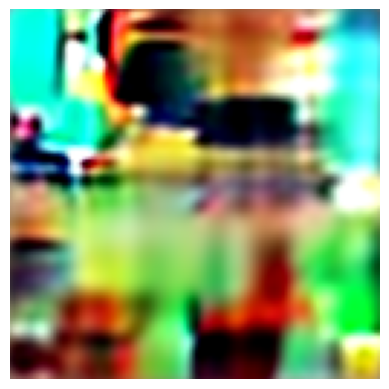

In [27]:
# one sample at class 207 (golden retriever)
y = torch.tensor([207, 1000], device=device)    # CFG: 207 + null class
z = torch.randn(2, 4, latent128, latent128, device=device)


# cast any float64 numpy arrays inside the diffusion object to float32
for k, v in list(diffusion.__dict__.items()):
    if isinstance(v, np.ndarray) and v.dtype == np.float64:
        diffusion.__dict__[k] = v.astype(np.float32)

with torch.no_grad():
    latents = diffusion.p_sample_loop(
        model128.forward_with_cfg, z.shape, z,
        clip_denoised=False, model_kwargs=dict(y=y, cfg_scale=10.0),
        progress=True, device=device
    )
    sample = latents[:1] / 0.18215
    img = vae.decode(sample).sample  # (1,3,256,256)

# img is (1, 3, 256, 256) in [-1, 1]
img_vis = img[0].detach().float().clamp(-1, 1)        # (3,H,W)
img_vis = (img_vis + 1) * 0.5                         # -> [0,1]
img_np  = img_vis.permute(1, 2, 0).cpu().numpy()      # (H,W,3) for plt

plt.imshow(img_np)
plt.axis("off")
plt.show()

**Unconditional Generation**

100%|██████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.46it/s]


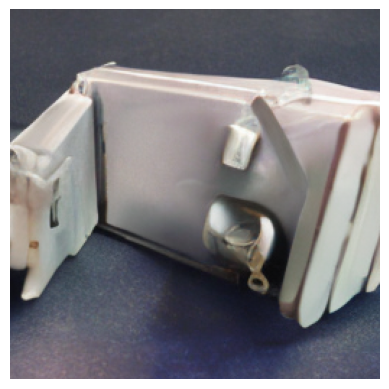

In [21]:
# assumes: model, diffusion, vae, image_size, latent, device already defined
# image_size in {256, 512}; latent = image_size // 8

import torch

n = 1  # how many images to generate
# Unconditional label = num_classes (ImageNet has 1000 classes, so null is 1000)
y = torch.full((n,), 1000, device=device, dtype=torch.long)

# Initial noise in VAE latent space (4 channels, downsampled by 8)
z = torch.randn(n, 4, latent, latent, device=device)

with torch.no_grad():
    latents = diffusion.p_sample_loop(
        model,                     # NOTE: not forward_with_cfg
        z.shape, z,
        clip_denoised=False,
        model_kwargs=dict(y=y),    # pass the null class labels
        progress=True,
        device=device
    )
    # SD VAE expects latents scaled by 1/0.18215
    img = vae.decode(latents / 0.18215).sample   # (n,3,H,W), in [-1,1]

# img is (1, 3, 256, 256) in [-1, 1]
img_vis = img[0].detach().float().clamp(-1, 1)        # (3,H,W)
img_vis = (img_vis + 1) * 0.5                         # -> [0,1]
img_np  = img_vis.permute(1, 2, 0).cpu().numpy()      # (H,W,3) for plt

plt.imshow(img_np)
plt.axis("off")
plt.show()